In [1]:
from __future__ import print_function
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt


In [15]:
# Input dimensions for an MNIST image
MNIST_W = 28
MNIST_H = 28

MNIST_DIM = MNIST_H*MNIST_W
NOISE_DIM = 100
BATCH_SIZE = 20
LEARN_RATE = 1e-4
MAX_EPOCH = 20

In [16]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,),(1,))])
trainset = torchvision.datasets.MNIST(root = '../data_MNIST',train = True, download = True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)
dataiter = iter(trainloader)


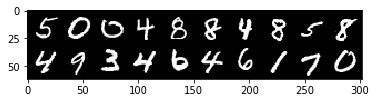

In [17]:
# Looking at data
img, _ = dataiter.next()
img_grid = torchvision.utils.make_grid(img,nrow = 10)
npimg_grid = img_grid.numpy()
plt.imshow(np.transpose(npimg_grid,(1,2,0)))


In [18]:
# Define the generator and discriminator networks
class Generator(nn.Module):

    def __init__(self):
        super(Generator,self).__init__()
        self.lin1 = nn.Linear(NOISE_DIM, 128)
#         self.bat1 = nn.BatchNorm1d(128)
        self.lin2 = nn.Linear(128, MNIST_DIM)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x),0.1)
#         x = self.bat1(x)
        x = F.sigmoid(self.lin2(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.lin1 = nn.Linear(MNIST_DIM, 128)
        self.bat1 = nn.BatchNorm1d(128)
        self.lin2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x),0.1)
#         x = self.bat1(x)
        x = F.sigmoid(self.lin2(x))
        return x



In [19]:
# Instantiate the networks and try some initial experiment to see what happens?
gen1 = Generator()
dis1 = Discriminator()

im_true, _ = dataiter.next()
vec_true = Variable(im_true[0:10,:]).view(-1,28*28)
prob_true = dis1(vec_true)
print(prob_true.data) # How does an untrained discriminator perform on true images?


 0.4712
 0.4890
 0.4854
 0.5048
 0.5024
 0.4940
 0.5083
 0.4842
 0.5071
 0.4741
[torch.FloatTensor of size 10x1]



In [20]:
# How does an untrained generator perform on untrained generator?
vec_false = gen1(Variable(torch.randn(10,NOISE_DIM)))
prob_false = dis1(vec_false)
print(prob_false.data)


 0.5305
 0.5231
 0.5301
 0.5254
 0.5271
 0.5286
 0.5274
 0.5319
 0.5303
 0.5236
[torch.FloatTensor of size 10x1]



In [21]:
smooth_labels = 1

gen1 = Generator()
dis1 = Discriminator()
gen_optimizer = optim.Adam(gen1.parameters(), lr = LEARN_RATE)
dis_optimizer = optim.Adam(dis1.parameters(), lr = LEARN_RATE)
criterion_dis = nn.BCELoss()
criterion_gen = nn.BCELoss()

In [22]:
LEARN_RATE = 1e-4
for epoch in range(MAX_EPOCH):
    dataiter = iter(trainloader)
    for i, data in enumerate(dataiter):
        true_im, _ = data
        dis_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        # Forward pass 'BATCH_SIZE' number of noise vectors through Generator
        noise_outputs = gen1(Variable(torch.randn(BATCH_SIZE,NOISE_DIM)))
        # Obtain 'BATCH_SIZE' number of true samples
        true_vec = true_im.view(-1,MNIST_DIM)
              
        # Forward pass "false" and true samples through the discriminator
        # and calculate the respective terms of discriminator loss
        if smooth_labels == 0:
            dis_true_loss = criterion_dis(dis1(Variable(true_vec)),Variable(torch.ones([BATCH_SIZE,1])))
            dis_false_loss = criterion_dis(dis1(noise_outputs),Variable(torch.zeros([BATCH_SIZE,1])))
        else:
            dis_true_loss = criterion_dis(dis1(Variable(true_vec)),Variable(0.9*torch.ones([BATCH_SIZE,1])))
            dis_false_loss = criterion_dis(dis1(noise_outputs),Variable(0.1*torch.ones([BATCH_SIZE,1])))
            
        # Calculate discriminator loss and backprop on discriminator params
        dis_loss = (dis_true_loss + dis_false_loss)
        dis_loss.backward()
        dis_optimizer.step()

        ## Generator update step
        dis_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        
        # Forward pass 'BATCH_SIZE' number of noise vectors through Generator, and the outputs through Discriminator		
        noise_outputs = gen1(Variable(torch.randn(BATCH_SIZE,NOISE_DIM)))

        # Calculate generator loss and backprop on generator params
        if smooth_labels == 0:
            gen_loss = criterion_gen(dis1(noise_outputs),Variable(torch.ones([BATCH_SIZE,1])))
        else:
            gen_loss = criterion_gen(dis1(noise_outputs),Variable(0.9*torch.ones([BATCH_SIZE,1])))    
        gen_loss.backward()
        gen_optimizer.step()


        if i % 100 == 0:
            print('iter: %3d dis_loss: %.3f gen_loss: %.3f  ' % (i, dis_loss.data, gen_loss.data) )
#             LEARN_RATE = LEARN_RATE*0.99
#             gen_optimizer = optim.Adam(gen1.parameters(), lr = LEARN_RATE)
#             dis_optimizer = optim.Adam(dis1.parameters(), lr = LEARN_RATE)
#     LEARN_RATE = 0.99*LEARN_RATE
#     gen_optimizer = optim.Adam(gen1.parameters(), lr = LEARN_RATE)
#     dis_optimizer = optim.Adam(dis1.parameters(), lr = LEARN_RATE)
       
    
    print('One Epoch completed')
    # Should save the model at this checkpoint
    

iter:   0 dis_loss: 1.402 gen_loss: 0.697  
iter: 100 dis_loss: 0.663 gen_loss: 2.032  
iter: 200 dis_loss: 0.676 gen_loss: 2.076  
iter: 300 dis_loss: 0.679 gen_loss: 2.143  
iter: 400 dis_loss: 0.706 gen_loss: 1.926  
iter: 500 dis_loss: 0.736 gen_loss: 2.227  
iter: 600 dis_loss: 0.830 gen_loss: 1.737  
iter: 700 dis_loss: 0.802 gen_loss: 1.817  
iter: 800 dis_loss: 0.799 gen_loss: 1.609  
iter: 900 dis_loss: 0.808 gen_loss: 1.548  
iter: 1000 dis_loss: 0.753 gen_loss: 1.573  
iter: 1100 dis_loss: 0.777 gen_loss: 1.556  
iter: 1200 dis_loss: 0.736 gen_loss: 1.650  
iter: 1300 dis_loss: 0.723 gen_loss: 1.594  
iter: 1400 dis_loss: 0.715 gen_loss: 1.615  
iter: 1500 dis_loss: 0.723 gen_loss: 1.515  
iter: 1600 dis_loss: 0.729 gen_loss: 1.482  
iter: 1700 dis_loss: 0.857 gen_loss: 1.426  
iter: 1800 dis_loss: 0.870 gen_loss: 1.389  
iter: 1900 dis_loss: 0.809 gen_loss: 1.175  
iter: 2000 dis_loss: 0.751 gen_loss: 1.181  
iter: 2100 dis_loss: 0.794 gen_loss: 1.201  
iter: 2200 dis_loss:

iter: 100 dis_loss: 0.828 gen_loss: 1.568  
iter: 200 dis_loss: 0.933 gen_loss: 1.429  
iter: 300 dis_loss: 0.856 gen_loss: 1.550  
iter: 400 dis_loss: 0.854 gen_loss: 1.561  
iter: 500 dis_loss: 0.963 gen_loss: 1.582  
iter: 600 dis_loss: 0.899 gen_loss: 1.259  
iter: 700 dis_loss: 0.799 gen_loss: 1.413  
iter: 800 dis_loss: 0.813 gen_loss: 1.394  
iter: 900 dis_loss: 0.859 gen_loss: 1.354  
iter: 1000 dis_loss: 0.979 gen_loss: 1.495  
iter: 1100 dis_loss: 0.887 gen_loss: 1.301  
iter: 1200 dis_loss: 0.846 gen_loss: 1.459  
iter: 1300 dis_loss: 0.832 gen_loss: 1.558  
iter: 1400 dis_loss: 0.849 gen_loss: 1.522  
iter: 1500 dis_loss: 0.870 gen_loss: 1.592  
iter: 1600 dis_loss: 0.904 gen_loss: 1.711  
iter: 1700 dis_loss: 0.887 gen_loss: 1.500  
iter: 1800 dis_loss: 0.823 gen_loss: 1.487  
iter: 1900 dis_loss: 0.935 gen_loss: 1.357  
iter: 2000 dis_loss: 0.821 gen_loss: 1.500  
iter: 2100 dis_loss: 0.920 gen_loss: 1.557  
iter: 2200 dis_loss: 0.864 gen_loss: 1.565  
iter: 2300 dis_loss

iter: 200 dis_loss: 0.885 gen_loss: 1.471  
iter: 300 dis_loss: 0.891 gen_loss: 1.125  
iter: 400 dis_loss: 0.863 gen_loss: 1.560  
iter: 500 dis_loss: 0.958 gen_loss: 1.458  
iter: 600 dis_loss: 0.818 gen_loss: 1.541  
iter: 700 dis_loss: 0.937 gen_loss: 1.615  
iter: 800 dis_loss: 0.922 gen_loss: 1.587  
iter: 900 dis_loss: 0.842 gen_loss: 1.421  
iter: 1000 dis_loss: 0.885 gen_loss: 1.542  
iter: 1100 dis_loss: 0.928 gen_loss: 1.210  
iter: 1200 dis_loss: 0.929 gen_loss: 1.239  
iter: 1300 dis_loss: 1.028 gen_loss: 1.410  
iter: 1400 dis_loss: 0.897 gen_loss: 1.539  
iter: 1500 dis_loss: 0.965 gen_loss: 1.602  
iter: 1600 dis_loss: 0.912 gen_loss: 1.415  
iter: 1700 dis_loss: 0.898 gen_loss: 1.497  
iter: 1800 dis_loss: 0.879 gen_loss: 1.352  
iter: 1900 dis_loss: 0.862 gen_loss: 1.294  
iter: 2000 dis_loss: 0.835 gen_loss: 1.324  
iter: 2100 dis_loss: 0.894 gen_loss: 1.720  
iter: 2200 dis_loss: 0.809 gen_loss: 1.707  
iter: 2300 dis_loss: 0.818 gen_loss: 1.450  
iter: 2400 dis_los

iter: 300 dis_loss: 0.967 gen_loss: 1.651  
iter: 400 dis_loss: 0.907 gen_loss: 1.116  
iter: 500 dis_loss: 0.852 gen_loss: 1.263  
iter: 600 dis_loss: 0.975 gen_loss: 1.495  
iter: 700 dis_loss: 0.843 gen_loss: 1.695  
iter: 800 dis_loss: 0.857 gen_loss: 1.441  
iter: 900 dis_loss: 0.865 gen_loss: 1.625  
iter: 1000 dis_loss: 0.860 gen_loss: 1.676  
iter: 1100 dis_loss: 0.948 gen_loss: 1.516  
iter: 1200 dis_loss: 0.898 gen_loss: 1.419  
iter: 1300 dis_loss: 0.896 gen_loss: 1.568  
iter: 1400 dis_loss: 0.942 gen_loss: 1.399  
iter: 1500 dis_loss: 0.892 gen_loss: 1.331  
iter: 1600 dis_loss: 0.857 gen_loss: 1.854  
iter: 1700 dis_loss: 0.837 gen_loss: 1.615  
iter: 1800 dis_loss: 0.892 gen_loss: 1.529  
iter: 1900 dis_loss: 0.839 gen_loss: 1.402  
iter: 2000 dis_loss: 0.850 gen_loss: 1.348  
iter: 2100 dis_loss: 0.945 gen_loss: 1.523  
iter: 2200 dis_loss: 0.880 gen_loss: 1.656  
iter: 2300 dis_loss: 0.932 gen_loss: 1.448  
iter: 2400 dis_loss: 0.825 gen_loss: 1.789  
iter: 2500 dis_lo

In [23]:
# Couple of sanity checks
# See if the discriminator is good enough to classify true images as true
print(BATCH_SIZE)
dataiter = iter(trainloader)
im_true, _ = dataiter.next()
vec_true = Variable(im_true[0:20,:]).view(-1,28*28)
prob_true = dis1(vec_true)
print(prob_true.data) # How does a trained discriminator perform on true images?

20

 0.2189
 0.9176
 0.2486
 0.5375
 0.7919
 0.9411
 0.9368
 0.9717
 0.4788
 0.9710
 0.9512
 0.8600
 0.9241
 0.9105
 0.4043
 0.8643
 0.8704
 0.8305
 0.9570
 0.3949
[torch.FloatTensor of size 20x1]



In [24]:
# How good is the current discriminator at detecting false images?
false_vec = gen1(Variable(torch.randn(20,NOISE_DIM)))
false_prob = dis1(false_vec)
print(false_prob.data)


 0.2405
 0.1069
 0.1316
 0.2052
 0.2414
 0.2539
 0.1324
 0.1430
 0.1223
 0.3215
 0.0930
 0.2563
 0.1597
 0.1777
 0.2662
 0.2652
 0.1674
 0.1895
 0.2680
 0.3521
[torch.FloatTensor of size 20x1]



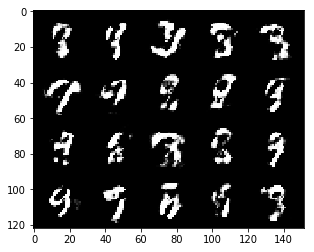

In [27]:
# Look at the generated images
false_vec = gen1(Variable(torch.randn(20,NOISE_DIM)))
false_im = false_vec.view(-1,1,28,28)
false_im_grid = torchvision.utils.make_grid(false_im.data,nrow = 5)
np_im_grid = false_im_grid.numpy()
plt.imshow(np.transpose(np_im_grid,(1,2,0)))
